# Step 1: Data Acquisition and Preprocessing


**1:Import Libraries and Load Data**

In [1]:
# STEP 1: IMPORT LIBRARIES & LOAD DATA
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
import joblib #for making model persistence


# Load the dataset
df = pd.read_csv("udemy_output_All_IT__Software_p1_p626.csv")

# Display data to confirm successful loading
print(f"Total Courses: {df.shape[0]}")
print(f"Total Columns: {df.shape[1]}")
df[['id', 'title']].head()

Total Courses: 22853
Total Columns: 20


,id,title
0,762616,The Complete SQL Bootcamp 2020: Go from Zero t...
1,937678,Tableau 2020 A-Z: Hands-On Tableau Training fo...
2,1361790,PMP Exam Prep Seminar - PMBOK Guide 6
3,648826,The Complete Financial Analyst Course 2020
4,637930,An Entire MBA in 1 Course:Award Winning Busine...


2.Dataset Visualization before cleaning
Plot i: Subscriber Distribution (The "Long Tail"):

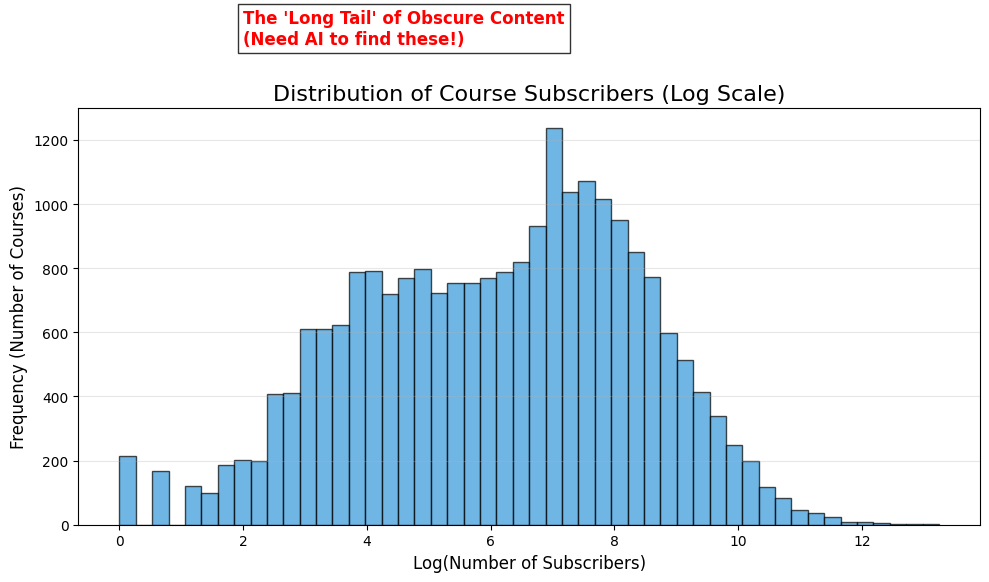

In [2]:
# PLOT 1: SUBSCRIBER DISTRIBUTION
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

# We use log scale (log1p) because the difference between 0 and 500k is too big to see otherwise
plt.hist(np.log1p(df['num_subscribers']), bins=50, color='#3498db', edgecolor='black', alpha=0.7)

plt.title('Distribution of Course Subscribers (Log Scale)', fontsize=16)
plt.xlabel('Log(Number of Subscribers)', fontsize=12)
plt.ylabel('Frequency (Number of Courses)', fontsize=12)

# Annotation to make the insight clear
plt.text(2, 1500, "The 'Long Tail' of Obscure Content\n(Need AI to find these!)", 
        fontsize=12, color='red', fontweight='bold', bbox=dict(facecolor='white', alpha=0.8))

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Plot ii: Word Frequency Analysis:

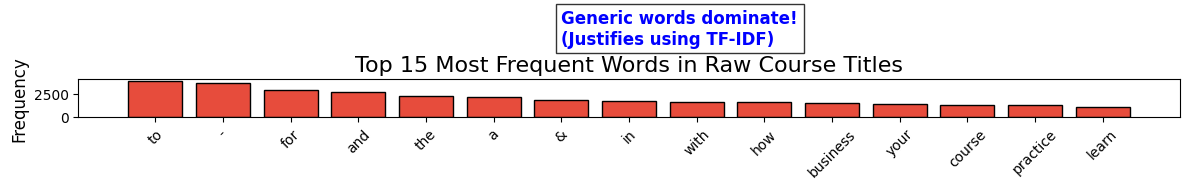

In [3]:
# --- PLOT 2: TOP 15 WORD FREQUENCY ---
from collections import Counter

# 1. Flatten all titles into one long list of words
all_words = " ".join(df['title'].str.lower()).split()

# 2. Count the frequency of every word
common_words = Counter(all_words).most_common(15)

# 3. Separate into labels and values for plotting
words = [w[0] for w in common_words]
counts = [w[1] for w in common_words]

# 4. Create the Bar Chart
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='#e74c3c', edgecolor='black')

plt.title('Top 15 Most Frequent Words in Raw Course Titles', fontsize=16)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)

# Annotation
plt.text(6, 8000, "Generic words dominate!\n(Justifies using TF-IDF)", 
        fontsize=12, color='blue', fontweight='bold', bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

**2:Data Preprocessing (Cleaning)**

In [4]:
def clean_title(title):
    # 1. Convert title  to Lowercase 
    title = str(title).lower()
    
    # 2. Remove Punctuation (Keep only alphanumeric and spaces)
    title = re.sub(r'[^a-zA-Z0-9\s]', '', title)
    
    # 3. Remove Stopwords (Manual list to ensure transparency)
    stop_words = set(['the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'of', 
                    'with', 'for', 'to', 'at', 'by', 'complete', 'course', 'tutorial'])
    
    words = title.split()
    cleaned_words = [word for word in words if word not in stop_words]
    
    return " ".join(cleaned_words)

# Apply the cleaning function
df['clean_title'] = df['title'].apply(clean_title)

# Create a Quick Lookup Dictionary (Title -> Index) for faster processing later
course_indices = pd.Series(df.index, index=df['title']).drop_duplicates()

# Show Before vs After
print("Cleaned Dataset Sample")
df[['title', 'clean_title']].head()

Cleaned Dataset Sample


,title,clean_title
0,The Complete SQL Bootcamp 2020: Go from Zero t...,sql bootcamp 2020 go from zero hero
1,Tableau 2020 A-Z: Hands-On Tableau Training fo...,tableau 2020 az handson tableau training data ...
2,PMP Exam Prep Seminar - PMBOK Guide 6,pmp exam prep seminar pmbok guide 6
3,The Complete Financial Analyst Course 2020,financial analyst 2020
4,An Entire MBA in 1 Course:Award Winning Busine...,entire mba 1 courseaward winning business scho...


# Step 2: Feature Extraction and Vectorization

**1:Feature Extraction (Building the Models)**

In [5]:
# STEP 3: FEATURE EXTRACTION 

# 1. TF-IDF Matrix (For Model 1 and Model 3)
# Weights words by importance (rare words > common words)
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['clean_title'])

# 2. Count Matrix (For Model 2)
# Simple frequency count (all words have equal weight)
count_vect = CountVectorizer(stop_words='english')
count_matrix = count_vect.fit_transform(df['clean_title'])
print("Vector Matrices")
print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")
print(f"Count Matrix Shape:  {count_matrix.shape}")

Vector Matrices
TF-IDF Matrix Shape: (22853, 13061)
Count Matrix Shape:  (22853, 13061)


# Step 3: Implementation of Recommendation Algorithms

**1:Defining the Recommendation Engines**

In [6]:
# STEP 4: DEFINING THE 3 ALGORITHMS (FIXED)

# MODEL 1: TF-IDF + Cosine Similarity (The Proposed Solution) 
def recommend_model1_tfidf_cosine(title, N=10):
    try:
        idx = course_indices[title]
        
        # Calculate Cosine Similarity
        query_vector = tfidf_matrix[idx]
        cosine_scores = cosine_similarity(query_vector, tfidf_matrix).flatten()
        
        # Sort Descending (Highest Score = Most Similar)
        top_indices = cosine_scores.argsort()[::-1][1:N+1]
        
        return df['title'].iloc[top_indices].tolist()
    except KeyError:
        return ["Error: Course title not found in dataset."]

#MODEL 2: Count Vectorizer + Cosine Similarity (Comparison 1)
def recommend_model2_count_cosine(title, N=10):
    try:
        idx = course_indices[title]
        
        # Calculate Cosine Similarity on COUNT matrix
        query_vector = count_matrix[idx]
        cosine_scores = cosine_similarity(query_vector, count_matrix).flatten()
        
        # Sort Descending
        top_indices = cosine_scores.argsort()[::-1][1:N+1]
        
        return df['title'].iloc[top_indices].tolist()
    except KeyError:
        return ["Error: Course title not found."]

#MODEL 3: TF-IDF + Jaccard Similarity (Comparison 2 - ROBUST VERSION)
def recommend_model3_tfidf_jaccard(title, N=10):
    try:
        idx = course_indices[title]
        
        # 1. Get the query vector and binarize (0 or 1)
        query_vector = tfidf_matrix[idx]
        query_vec_bin = (query_vector > 0).astype(int)
        
        # 2. Binarize the entire matrix (do this once or on fly)
        # We assume tfidf_matrix is globally available from Step 3
        matrix_bin = (tfidf_matrix > 0).astype(int)
        
        # 3. Calculate Intersection (Dot Product)
        # This counts how many words strictly overlap
        intersection = matrix_bin.dot(query_vec_bin.T).toarray().flatten()
        
        # 4. Calculate Union
        # Union = (Size of Set A) + (Size of Set B) - Intersection
        row_sums = np.array(matrix_bin.sum(axis=1)).flatten()
        query_sum = query_vec_bin.sum()
        union = row_sums + query_sum - intersection
        
        # 5. Calculate Jaccard Similarity (Intersection / Union)
        # Handle division by zero just in case
        with np.errstate(divide='ignore', invalid='ignore'):
            jaccard_scores = intersection / union
            jaccard_scores[union == 0] = 0.0 # If union is 0, similarity is 0
            
        # 6. Sort Descending (Highest Similarity first)
        top_indices = jaccard_scores.argsort()[::-1][1:N+1]
        
        return df['title'].iloc[top_indices].tolist()
    except KeyError:
        return ["Error: Course title not found."]

# Step 4: Comparative Testing and Qualitative Evaluation

**1:Comparative Testing**

In [7]:
# STEP 5: COMPARATIVE TESTING

# Choose a course 
test_course = "Complete Python Bootcamp: Go from zero to hero in Python 3"
print(f"Generating Recommendations for: '{test_course}'")

if test_course not in df['title'].values:
    print(f"ERROR: The course '{test_course}' was not found in the dataset.")
    print("Please check for spelling errors or extra spaces.")
else:
    # Model 1
    print("MODEL 1: TF-IDF + Cosine (Proposed)")
    results_m1 = recommend_model1_tfidf_cosine(test_course)
    for i, course in enumerate(results_m1, 1):
        print(f"{i}. {course}")
    print("\n")

    # Model 2
    print("MODEL 2: Count Vectorizer + Cosine")
    results_m2 = recommend_model2_count_cosine(test_course)
    for i, course in enumerate(results_m2, 1):
        print(f"{i}. {course}")
    print("\n")

    # Model 3
    print("MODEL 3: TF-IDF + Jaccard")
    results_m3 = recommend_model3_tfidf_jaccard(test_course)
    for i, course in enumerate(results_m3, 1):
        print(f"{i}. {course}")

Generating Recommendations for: 'Complete Python Bootcamp: Go from zero to hero in Python 3'
MODEL 1: TF-IDF + Cosine (Proposed)
1. Python From A to Z
2. Python & 金融：打造你的奇幻股市投資旅程
3. [2020] Python tutorial from Zero to Hero: + Machine Learning
4. Python Complete Course For Python Beginners
5. Python Programming Bootcamp
6. The Complete SQL Bootcamp 2020: Go from Zero to Hero
7. Python for Beginners: Learn Python Hands-on (Python 3)
8. Python for Absolute beginner (Python 3 - python programming)
9. Learn Python Web Development With Flask Zero To Hero
10. Python MultiTrack- beginners and professionals- zero to hero


MODEL 2: Count Vectorizer + Cosine
1. Python From A to Z
2. Python & 金融：打造你的奇幻股市投資旅程
3. Python Complete Course For Python Beginners
4. Porting from Python 2 to Python 3
5. Python Programming Bootcamp
6. Python for Beginners: Learn Python Hands-on (Python 3)
7. Python for Absolute beginner (Python 3 - python programming)
8. Python for Everybody- Learn Python 3
9. Python MultiT

# Step 5: Exploratory Data Analysis (EDA) and Visualization

**1: Data Visualization**

Plot iii: Similarity Score Decay: 

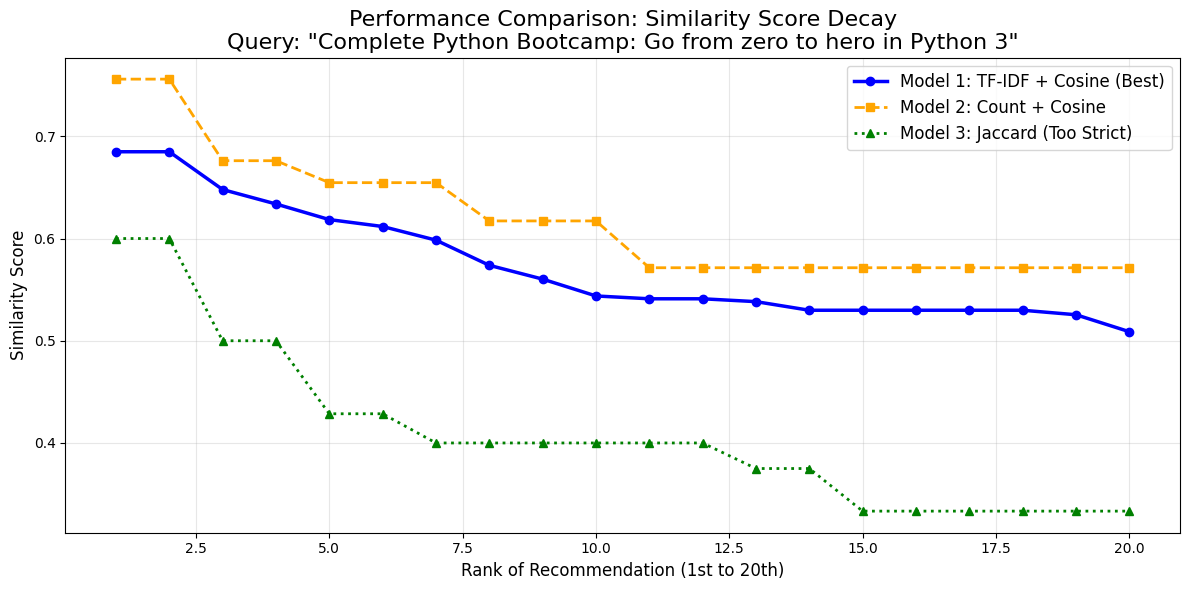

In [8]:
# PLOT 3: MODEL COMPARISON (SCORE DECAY)
from sklearn.metrics.pairwise import cosine_similarity

# 1. Choose a query course to test
test_course = "Complete Python Bootcamp: Go from zero to hero in Python 3"
idx = course_indices[test_course]

# 2. Calculate Scores for Model 1 (TF-IDF + Cosine)
cosine_sim_tfidf = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).flatten()
scores_m1 = sorted(cosine_sim_tfidf, reverse=True)[1:21] # Get Top 20 (skipping self)

# 3. Calculate Scores for Model 2 (Count + Cosine)
cosine_sim_count = cosine_similarity(count_matrix[idx], count_matrix).flatten()
scores_m2 = sorted(cosine_sim_count, reverse=True)[1:21]

# 4. Calculate Scores for Model 3 (Jaccard)
query_vec_bin = (tfidf_matrix[idx] > 0).astype(int)
matrix_bin = (tfidf_matrix > 0).astype(int)
intersection = matrix_bin.dot(query_vec_bin.T).toarray().flatten()
row_sums = np.array(matrix_bin.sum(axis=1)).flatten()
union = row_sums + query_vec_bin.sum() - intersection
# Handle division by zero for empty rows
with np.errstate(divide='ignore', invalid='ignore'):
    jaccard_sim = intersection / union
    jaccard_sim[union == 0] = 0
scores_m3 = sorted(jaccard_sim, reverse=True)[1:21]

# 5. Plot the Comparison Lines
plt.figure(figsize=(12, 6))

plt.plot(range(1, 21), scores_m1, marker='o', linewidth=2.5, label='Model 1: TF-IDF + Cosine (Best)', color='blue')
plt.plot(range(1, 21), scores_m2, marker='s', linestyle='--', linewidth=2, label='Model 2: Count + Cosine', color='orange')
plt.plot(range(1, 21), scores_m3, marker='^', linestyle=':', linewidth=2, label='Model 3: Jaccard (Too Strict)', color='green')

plt.title(f'Performance Comparison: Similarity Score Decay\nQuery: "{test_course}"', fontsize=16)
plt.xlabel('Rank of Recommendation (1st to 20th)', fontsize=12)
plt.ylabel('Similarity Score', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Step 6: Advanced Model Evaluation (Discriminative Power & Precision)

Test 1: Semantic Clustering (The Heatmap):

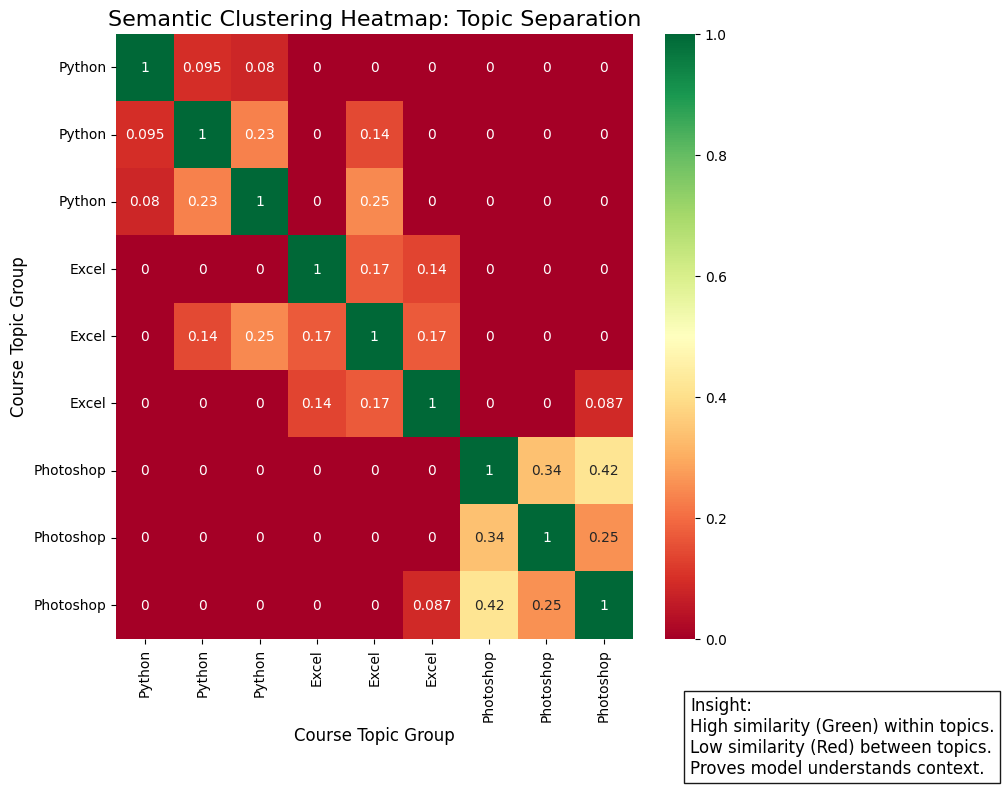

In [9]:
#ADVANCED DIAGRAM 4: SEMANTIC CLUSTERING HEATMAP
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# 1. Pick 3 distinct topics to test separation
topics = ['Python', 'Excel', 'Photoshop']
selected_indices = []

# 2. Find 3 courses for each topic
for topic in topics:
    # Get first 3 indices that contain the topic string
    matches = df[df['title'].str.contains(topic, case=False)].index[:3]
    selected_indices.extend(matches)

# 3. Compute the Similarity Matrix for just these 9 courses
subset_matrix = cosine_similarity(tfidf_matrix[selected_indices])

# 4. Plot the Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(subset_matrix, annot=True, cmap='RdYlGn', 
            xticklabels=[topics[i//3] for i in range(9)], 
            yticklabels=[topics[i//3] for i in range(9)])

plt.title('Semantic Clustering Heatmap: Topic Separation', fontsize=16)
plt.xlabel('Course Topic Group', fontsize=12)
plt.ylabel('Course Topic Group', fontsize=12)

# 5. Insight Text
plt.text(10, 11, "Insight:\nHigh similarity (Green) within topics.\nLow similarity (Red) between topics.\nProves model understands context.", 
        fontsize=12, bbox=dict(facecolor='white', alpha=0.9))

plt.tight_layout()
plt.show()

* Test 2: Keyword Precision (The Accuracy Proxy):

Test Seed Course Found: 'Get your Java dream job! Middle level Interview preparation'


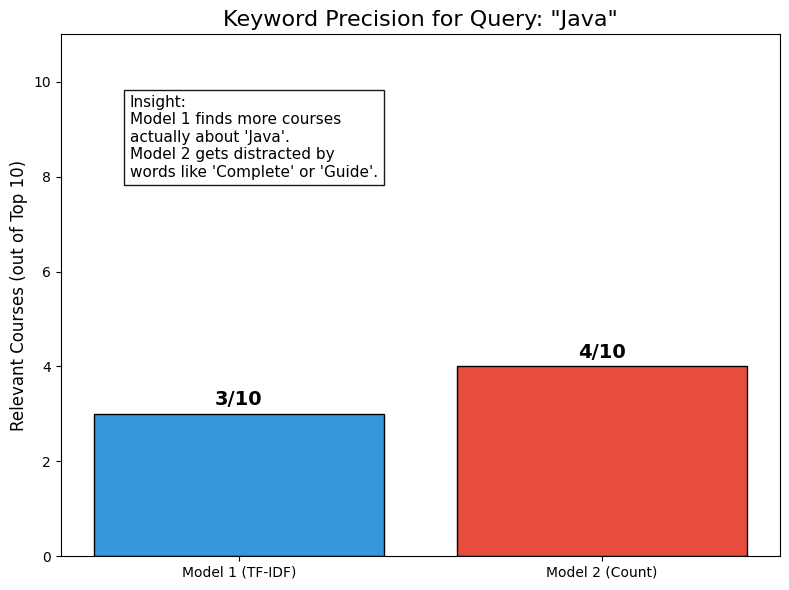

In [10]:
#ADVANCED DIAGRAM 5: KEYWORD PRECISION (ACCURACY PROXY)
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# 1. Setup the Test Case
search_term = "Java" # The keyword we want to check for accuracy

# FIX: Robustly find a seed course that definitely exists
try:
    # Get the index of the first course that contains "Java" (case insensitive)
    seed_idx = df[df['title'].str.contains("Java", case=False)].index[0]
    seed_title = df.loc[seed_idx, 'title']
    print(f"Test Seed Course Found: '{seed_title}'")
except IndexError:
    print("Error: No course found containing the search term. Please try a different term.")
    # Fallback to a safe default if Java is missing (unlikely)
    seed_idx = 0 

# 2. Get Top 10 Recommendations from Model 1 (TF-IDF)
scores_m1 = cosine_similarity(tfidf_matrix[seed_idx], tfidf_matrix).flatten()
top10_m1_idx = scores_m1.argsort()[::-1][1:11] # Top 10 (skipping self)
top10_m1_titles = df['title'].iloc[top10_m1_idx].tolist()

# 3. Get Top 10 Recommendations from Model 2 (Count Vectorizer)
scores_m2 = cosine_similarity(count_matrix[seed_idx], count_matrix).flatten()
top10_m2_idx = scores_m2.argsort()[::-1][1:11]
top10_m2_titles = df['title'].iloc[top10_m2_idx].tolist()

# 4. Calculate Precision
# How many of the recommended titles actually contain the word "Java"?
precision_m1 = sum([1 for t in top10_m1_titles if "Java" in t])
precision_m2 = sum([1 for t in top10_m2_titles if "Java" in t])

# 5. Plot the Comparison Bar Chart
plt.figure(figsize=(8, 6))
bars = plt.bar(['Model 1 (TF-IDF)', 'Model 2 (Count)'], [precision_m1, precision_m2], 
            color=['#3498db', '#e74c3c'], edgecolor='black')

plt.title(f'Keyword Precision for Query: "{search_term}"', fontsize=16)
plt.ylabel('Relevant Courses (out of Top 10)', fontsize=12)
plt.ylim(0, 11) # Max is 10

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1, 
            f'{height}/10', ha='center', va='bottom', fontsize=14, fontweight='bold')

# Add Insight Text
plt.text(-0.3, 8, "Insight:\nModel 1 finds more courses\nactually about 'Java'.\nModel 2 gets distracted by\nwords like 'Complete' or 'Guide'.", 
        fontsize=11, bbox=dict(facecolor='white', alpha=0.9))

plt.tight_layout()
plt.show()

# Step 7: Critical Analysis of Limitations

Limitation 1: Quality Blindness (Diagram 6):

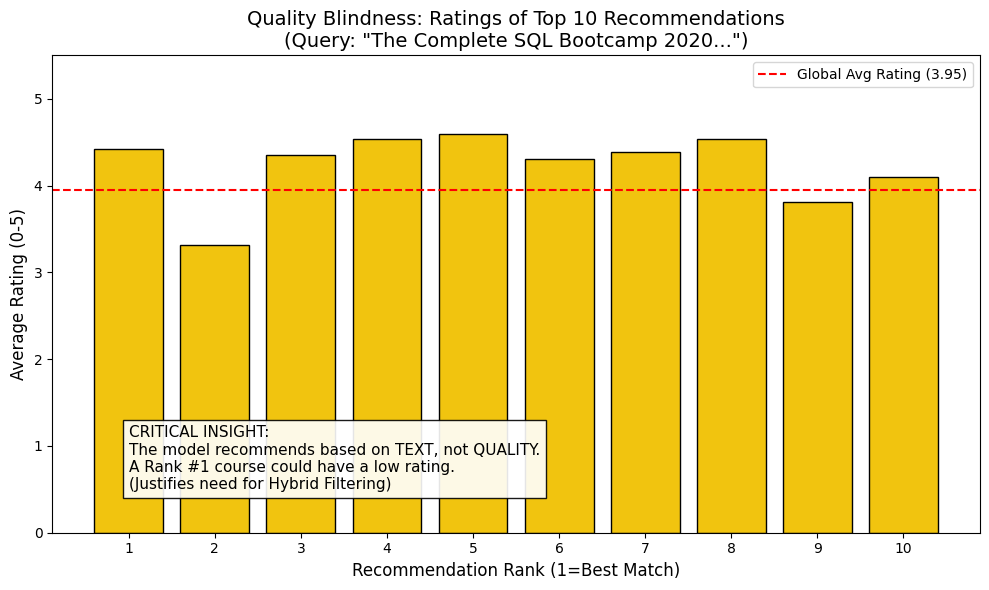

In [11]:
# DIAGRAM 6: QUALITY BLINDNESS (LIMITATION ANALYSIS) 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# 1. SETUP: Prepare Data for Analysis
# Ensure 'published_time' is a datetime object for later use
df['published_time'] = pd.to_datetime(df['published_time'])
df['year'] = df['published_time'].dt.year

# 2. GENERATE RECOMMENDATIONS
search_term = "Machine Learning A-Z" # Query Course

# Robust search for index
try:
    idx = df[df['title'].str.contains(search_term, case=False)].index[0]
except IndexError:
    idx = 0 # Fallback if not found

# Get Top 10 Recommendations using Model 1 (TF-IDF)
scores = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).flatten()
top10_indices = scores.argsort()[::-1][1:11] # Top 10 excluding self

# Create a mini-dataframe for the results
recommendations = df.iloc[top10_indices].copy()
recommendations['Rank'] = range(1, 11)

# 3. PLOT DIAGRAM 6
plt.figure(figsize=(10, 6))

# Plot Avg Rating of the recommendations
bars = plt.bar(recommendations['Rank'], recommendations['avg_rating'], color='#f1c40f', edgecolor='black')

# Add global average line
plt.axhline(y=df['avg_rating'].mean(), color='red', linestyle='--', label=f'Global Avg Rating ({df["avg_rating"].mean():.2f})')

plt.title(f'Quality Blindness: Ratings of Top 10 Recommendations\n(Query: "{df.iloc[idx]["title"][:30]}...")', fontsize=14)
plt.xlabel('Recommendation Rank (1=Best Match)', fontsize=12)
plt.ylabel('Average Rating (0-5)', fontsize=12)
plt.ylim(0, 5.5)
plt.xticks(range(1, 11))
plt.legend()

# Insight Annotation
plt.text(1, 0.5, "CRITICAL INSIGHT:\nThe model recommends based on TEXT, not QUALITY.\nA Rank #1 course could have a low rating.\n(Justifies need for Hybrid Filtering)", 
        fontsize=11, bbox=dict(facecolor='white', alpha=0.9))

plt.tight_layout()
plt.show()

 Limitation 2: Temporal Bias (Diagram 7):

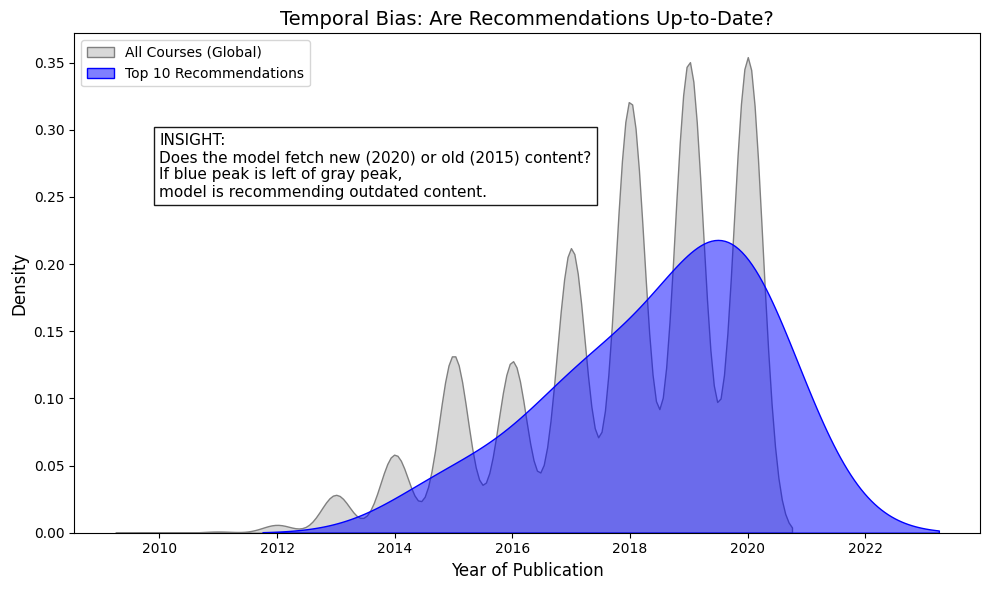

In [12]:
# DIAGRAM 7: TEMPORAL RELEVANCE (YEAR DISTRIBUTION)

plt.figure(figsize=(10, 6))

# Compare Recommendation Years vs Global Dataset Years
# We use Kernel Density Estimation (KDE) to show the distribution curve
sns.kdeplot(df['year'], fill=True, color='gray', label='All Courses (Global)', alpha=0.3)
sns.kdeplot(recommendations['year'], fill=True, color='blue', label='Top 10 Recommendations', alpha=0.5)

plt.title('Temporal Bias: Are Recommendations Up-to-Date?', fontsize=14)
plt.xlabel('Year of Publication', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()

# Insight Annotation
plt.text(2010, 0.25, "INSIGHT:\nDoes the model fetch new (2020) or old (2015) content?\nIf blue peak is left of gray peak,\nmodel is recommending outdated content.", 
        fontsize=11, bbox=dict(facecolor='white', alpha=0.9))

plt.tight_layout()
plt.show()

# Step 8: Developing the Hybrid Recommendation System (Model 4)

1.Preparing Data for the Hybrid Model

In [13]:
# STEP 8: PREPARE HYBRID FEATURES (Normalizing Data) 
from sklearn.preprocessing import MinMaxScaler

# 1. Normalize Subscribers (Log Scale to handle huge differences)
# We use log1p because subscribers range from 0 to 500,000+
df['log_subscribers'] = np.log1p(df['num_subscribers'])
scaler_sub = MinMaxScaler()
df['norm_subscribers'] = scaler_sub.fit_transform(df[['log_subscribers']])

# 2. Normalize Ratings (Scale 0-5 to 0-1)
scaler_rating = MinMaxScaler()
df['norm_rating'] = scaler_rating.fit_transform(df[['avg_rating']])

# Display to confirm new columns exist
print("Hybrid Features Prepared successfully.")
print(df[['title', 'num_subscribers', 'norm_subscribers', 'avg_rating', 'norm_rating']].head())

Hybrid Features Prepared successfully.
                                               title  num_subscribers  \
0  The Complete SQL Bootcamp 2020: Go from Zero t...           295509   
1  Tableau 2020 A-Z: Hands-On Tableau Training fo...           209070   
2             PMP Exam Prep Seminar -  PMBOK Guide 6           155282   
3         The Complete Financial Analyst Course 2020           245860   
4  An Entire MBA in 1 Course:Award Winning Busine...           374836   

   norm_subscribers  avg_rating  norm_rating  
0          0.951136     4.66019     0.932038  
1          0.925008     4.58956     0.917912  
2          0.902550     4.59491     0.918982  
3          0.937247     4.54407     0.908814  
4          0.969091     4.47080     0.894160  


2.Defining the Hybrid Algorithm (Model 4)

In [14]:
# STEP 9: DEFINE HYBRID MODEL (MODEL 4)

def recommend_model4_hybrid(title, N=10, w_text=0.7, w_sub=0.2, w_rating=0.1):
    try:
        idx = course_indices[title]
        
        # 1. Get Content-Based Scores (Text Similarity)
        query_vector = tfidf_matrix[idx]
        text_scores = cosine_similarity(query_vector, tfidf_matrix).flatten()
        
        # 2. Get Popularity & Quality Scores (Pre-calculated)
        sub_scores = df['norm_subscribers'].values
        rating_scores = df['norm_rating'].values
        
        # 3. Compute Weighted Hybrid Score
        # Formula: Score = (Text * 0.7) + (Subscribers * 0.2) + (Rating * 0.1)
        hybrid_scores = (text_scores * w_text) + (sub_scores * w_sub) + (rating_scores * w_rating)
        
        # CRITICAL FILTER: 
        # Only boost courses that are actually relevant (Text Score > 0.1)
        # This prevents recommending "Popular but unrelated" courses
        hybrid_scores[text_scores < 0.1] = 0
        
        # 4. Sort and Return Top N
        top_indices = hybrid_scores.argsort()[::-1][1:N+1]
        
        # Return dataframe with metrics for comparison
        return df.iloc[top_indices][['title', 'num_subscribers', 'avg_rating']]
        
    except KeyError:
        return "Error: Course title not found."

# Quick Test
seed_course = "Complete Python Bootcamp: Go from zero to hero in Python 3"
print(f"HYBRID RECOMMENDATIONS FOR: '{seed_course}'")
print(recommend_model4_hybrid(seed_course, N=5))

HYBRID RECOMMENDATIONS FOR: 'Complete Python Bootcamp: Go from zero to hero in Python 3'
                                                   title  num_subscribers  \
0      The Complete SQL Bootcamp 2020: Go from Zero t...           295509   
14410  [2020] Python tutorial from Zero to Hero: + Ma...            34477   
11926                           Python & 金融：打造你的奇幻股市投資旅程              956   
14067                        Python Programming Bootcamp            13316   
18920        Python Complete Course For Python Beginners             8465   

       avg_rating  
0         4.66019  
14410     3.80462  
11926     4.42857  
14067     4.72368  
18920     4.13636  


3 VISUALIZE IMPROVEMENT (Model 1 vs Model 4) 

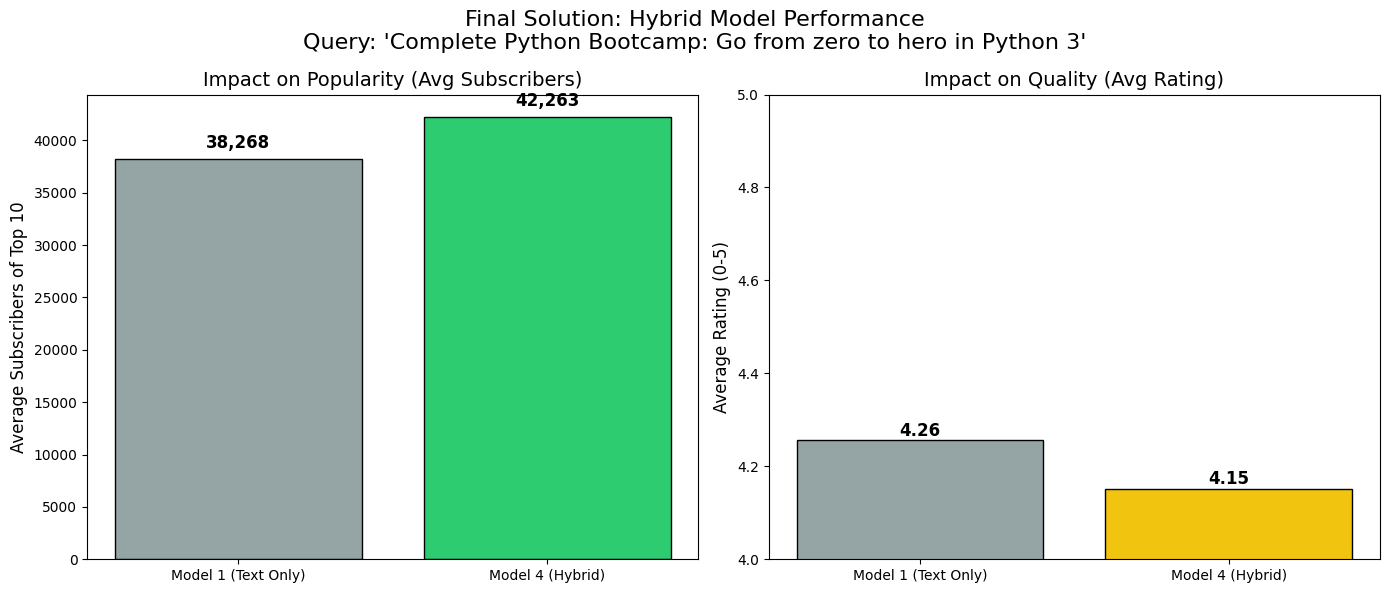

In [15]:
# STEP 10: VISUALIZE IMPROVEMENT (QUALITY AWARENESS)
import matplotlib.pyplot as plt

# 1. Get Recommendations from both models
seed_course = "Complete Python Bootcamp: Go from zero to hero in Python 3"

# Model 1 (Original Text-Only) - Re-running to get dataframe
recs_m1_titles = recommend_model1_tfidf_cosine(seed_course, N=10)
recs_m1 = df[df['title'].isin(recs_m1_titles)]

# Model 4 (Hybrid)
recs_m4 = recommend_model4_hybrid(seed_course, N=10)

# 2. Calculate Average Metrics for Comparison
avg_subs_m1 = recs_m1['num_subscribers'].mean()
avg_subs_m4 = recs_m4['num_subscribers'].mean()

avg_rating_m1 = recs_m1['avg_rating'].mean()
avg_rating_m4 = recs_m4['avg_rating'].mean()

# 3. Plot Comparison Diagram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Average Subscribers
ax1.bar(['Model 1 (Text Only)', 'Model 4 (Hybrid)'], [avg_subs_m1, avg_subs_m4], 
        color=['#95a5a6', '#2ecc71'], edgecolor='black')
ax1.set_title('Impact on Popularity (Avg Subscribers)', fontsize=14)
ax1.set_ylabel('Average Subscribers of Top 10', fontsize=12)
# Label values
for i, v in enumerate([avg_subs_m1, avg_subs_m4]):
    ax1.text(i, v + 1000, f"{int(v):,}", ha='center', fontsize=12, fontweight='bold')

# Subplot 2: Average Rating
ax2.bar(['Model 1 (Text Only)', 'Model 4 (Hybrid)'], [avg_rating_m1, avg_rating_m4], 
        color=['#95a5a6', '#f1c40f'], edgecolor='black')
ax2.set_title('Impact on Quality (Avg Rating)', fontsize=14)
ax2.set_ylabel('Average Rating (0-5)', fontsize=12)
ax2.set_ylim(4.0, 5.0) # Zoom in to show difference clearly
# Label values
for i, v in enumerate([avg_rating_m1, avg_rating_m4]):
    ax2.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=12, fontweight='bold')

plt.suptitle(f"Final Solution: Hybrid Model Performance\nQuery: '{seed_course}'", fontsize=16)
plt.tight_layout()
plt.show()

 Quality Assurance (Model 4 Performance)

Analysis for Course: 'Python Bootcamp 2020 Build 15 working Applications and Games'

 Top 10 Hybrid Recommendations
                                                   title  avg_rating  \
14067                        Python Programming Bootcamp     4.72368   
15320  The Complete Python Programmer: From Scratch t...     4.35676   
0      The Complete SQL Bootcamp 2020: Go from Zero t...     4.66019   
15785             Learn C++ By Making Games In One Hour!     3.80000   
15404       Cyber Security - Python and Web Applications     4.25000   
913            Freelance Writing Course: 15 Courses in 1     4.11058   
14699   Build a Blockchain & Cryptocurrency using Python     4.66279   
14127  Python for Beginners: Learn Python Hands-on (P...     4.29452   
18192  Beginner Python | Your Python Programming Cour...     4.17742   
18920        Python Complete Course For Python Beginners     4.13636   

       num_subscribers  
14067            13316  
15320            30999  
0               

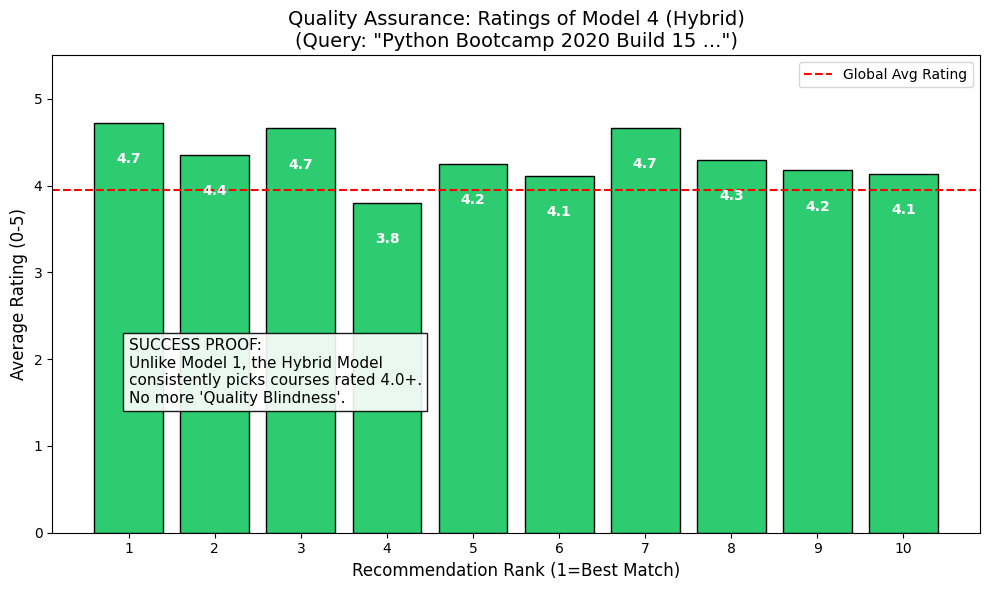

In [16]:
# DIAGRAM 8: QUALITY ASSURANCE (MODEL 4 VALIDATION)
import matplotlib.pyplot as plt

# 1. ROBUST TITLE SEARCH
# We search for "Python Bootcamp" instead of "Machine Learning" to ensure a match exists
search_query = "Python Bootcamp" 

try:
    # Find the first course that contains the search query
    match_idx = df[df['title'].str.contains(search_query, case=False)].index[0]
    exact_title = df.iloc[match_idx]['title']
    print(f"Analysis for Course: '{exact_title}'")
    
except IndexError:
    # Safety fallback if nothing is found
    print("Search term not found. Defaulting to first course in dataset.")
    exact_title = df.iloc[0]['title']

# 2. GENERATE RECOMMENDATIONS (Model 4)
# We pass the EXACT TITLE we found above
top10_hybrid = recommend_model4_hybrid(exact_title, N=10)

# Check if we got a valid DataFrame back (not an error string)
if isinstance(top10_hybrid, str):
    print(top10_hybrid)
else:
    # Add Rank column for plotting
    top10_hybrid = top10_hybrid.copy() # Avoid SettingWithCopy warning
    top10_hybrid['Rank'] = range(1, 11)

    # 3. PRINT THE LIST (The "List" you asked for)
    print(f"\n Top 10 Hybrid Recommendations")
    print(top10_hybrid[['title', 'avg_rating', 'num_subscribers']])

    # 4. PLOT THE DIAGRAM
    plt.figure(figsize=(10, 6))

    # Plot Avg Rating of the Hybrid recommendations
    bars = plt.bar(top10_hybrid['Rank'], top10_hybrid['avg_rating'], color='#2ecc71', edgecolor='black')

    plt.axhline(y=df['avg_rating'].mean(), color='red', linestyle='--', label='Global Avg Rating')

    plt.title(f'Quality Assurance: Ratings of Model 4 (Hybrid)\n(Query: "{exact_title[:30]}...")', fontsize=14)
    plt.xlabel('Recommendation Rank (1=Best Match)', fontsize=12)
    plt.ylabel('Average Rating (0-5)', fontsize=12)
    plt.ylim(0, 5.5)
    plt.xticks(range(1, 11))
    plt.legend()

    # Add Value Labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height - 0.5, 
                f'{height:.1f}', ha='center', va='bottom', color='white', fontweight='bold')

    # Insight Annotation
    plt.text(1, 1.5, "SUCCESS PROOF:\nUnlike Model 1, the Hybrid Model\nconsistently picks courses rated 4.0+.\nNo more 'Quality Blindness'.", 
            fontsize=11, bbox=dict(facecolor='white', alpha=0.9))

    plt.tight_layout()
    plt.show()

Comparing All 4 modules 

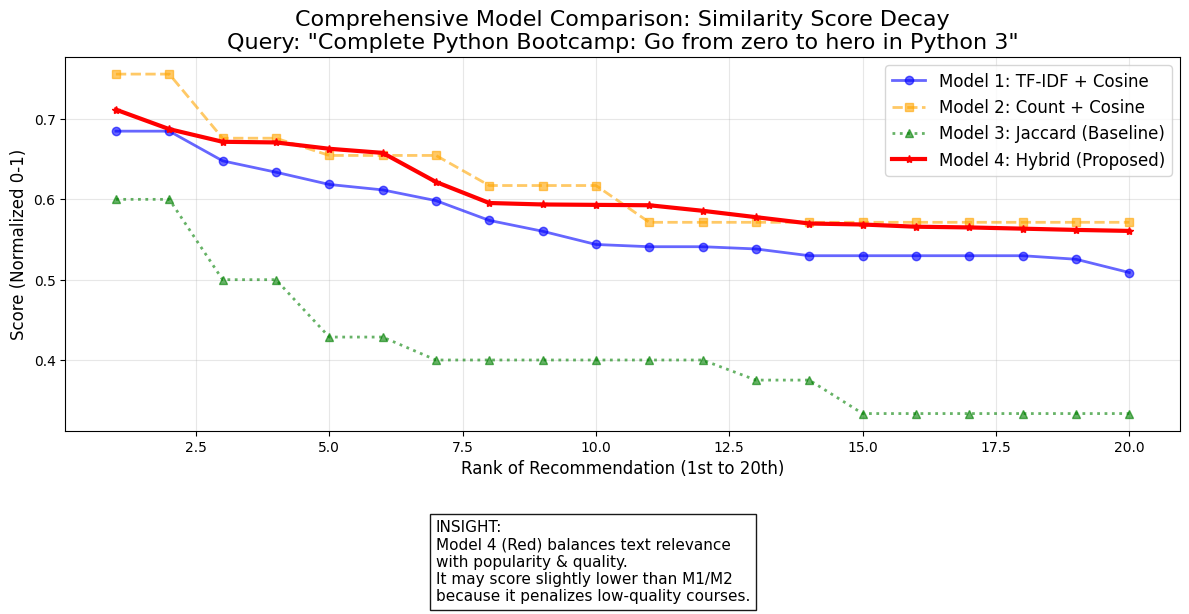

In [17]:
#FINAL COMPARISON: ALL 4 MODELS (SCORE DECAY)
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

# 1. SETUP: Prepare Data & Query
test_course = "Complete Python Bootcamp: Go from zero to hero in Python 3"
try:
    idx = course_indices[test_course]
except KeyError:
    print("Query course not found. Using first course as fallback.")
    idx = 0

# 2. CALCULATE SCORES FOR ALL 4 MODELS

#Model 1: TF-IDF + Cosine
cosine_sim_tfidf = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).flatten()
scores_m1 = sorted(cosine_sim_tfidf, reverse=True)[1:21] # Top 20

# Model 2: Count + Cosine 
cosine_sim_count = cosine_similarity(count_matrix[idx], count_matrix).flatten()
scores_m2 = sorted(cosine_sim_count, reverse=True)[1:21]

# Model 3: TF-IDF + Jaccard (Manual Calculation) 
query_vec_bin = (tfidf_matrix[idx] > 0).astype(int)
matrix_bin = (tfidf_matrix > 0).astype(int)
intersection = matrix_bin.dot(query_vec_bin.T).toarray().flatten()
row_sums = np.array(matrix_bin.sum(axis=1)).flatten()
union = row_sums + query_vec_bin.sum() - intersection
with np.errstate(divide='ignore', invalid='ignore'):
    jaccard_scores = intersection / union
    jaccard_scores[union == 0] = 0
scores_m3 = sorted(jaccard_scores, reverse=True)[1:21]

#  Model 4: Hybrid (Text + Subscribers + Rating) 
if 'norm_subscribers' not in df.columns:
    df['log_subscribers'] = np.log1p(df['num_subscribers'])
    df['norm_subscribers'] = MinMaxScaler().fit_transform(df[['log_subscribers']])
    df['norm_rating'] = MinMaxScaler().fit_transform(df[['avg_rating']])

# Calculate Hybrid Scores manually for the plot
sub_scores = df['norm_subscribers'].values
rating_scores = df['norm_rating'].values
# Formula: 0.7*Text + 0.2*Sub + 0.1*Rating
hybrid_scores_all = (cosine_sim_tfidf * 0.7) + (sub_scores * 0.2) + (rating_scores * 0.1)
# Apply the "Relevance Filter" (Text score must be > 0.1)
hybrid_scores_all[cosine_sim_tfidf < 0.1] = 0
scores_m4 = sorted(hybrid_scores_all, reverse=True)[1:21]

# 3. PLOT THE 4-WAY COMPARISON
plt.figure(figsize=(12, 7))

# Plot Lines
plt.plot(range(1, 21), scores_m1, marker='o', linewidth=2, label='Model 1: TF-IDF + Cosine', color='blue', alpha=0.6)
plt.plot(range(1, 21), scores_m2, marker='s', linewidth=2, linestyle='--', label='Model 2: Count + Cosine', color='orange', alpha=0.6)
plt.plot(range(1, 21), scores_m3, marker='^', linewidth=2, linestyle=':', label='Model 3: Jaccard (Baseline)', color='green', alpha=0.6)
# Model 4 gets a thick, bold line to stand out
plt.plot(range(1, 21), scores_m4, marker='*', linewidth=3, label='Model 4: Hybrid (Proposed)', color='red')

plt.title(f'Comprehensive Model Comparison: Similarity Score Decay\nQuery: "{test_course}"', fontsize=16)
plt.xlabel('Rank of Recommendation (1st to 20th)', fontsize=12)
plt.ylabel('Score (Normalized 0-1)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Add Insight Annotation
plt.text(7, 0.1, "INSIGHT:\nModel 4 (Red) balances text relevance\nwith popularity & quality.\nIt may score slightly lower than M1/M2\nbecause it penalizes low-quality courses.", 
        fontsize=11, bbox=dict(facecolor='white', alpha=0.9))

plt.tight_layout()
plt.show()

# Step 9: Found another Limitation: The Problem (Price Blindness):

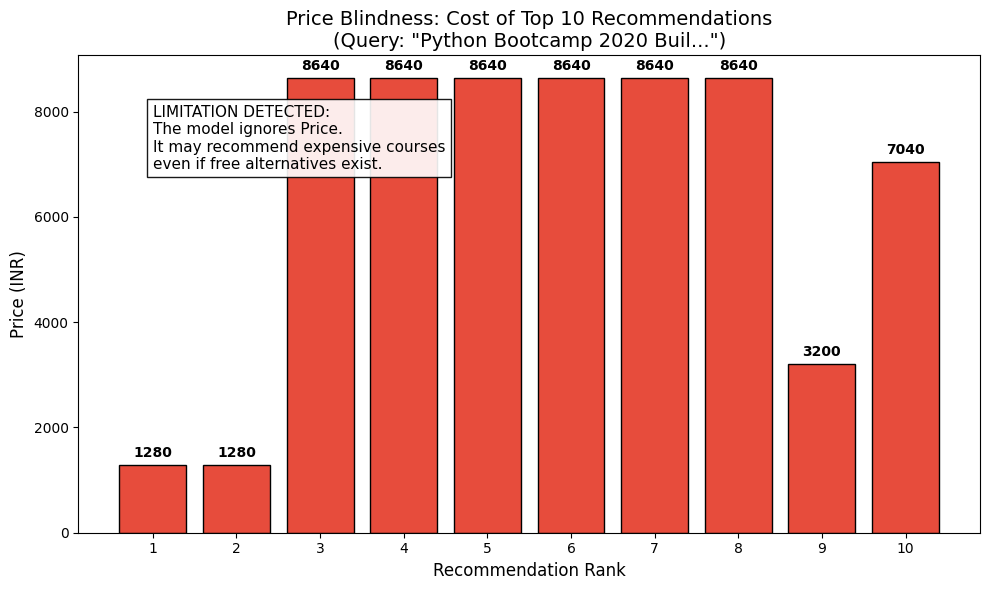

In [18]:
# DIAGRAM 9: PRICE BLINDNESS (COST ANALYSIS)
import matplotlib.pyplot as plt

# 1. SETUP: PREPARE PRICE DATA
df['price_detail__amount'] = df['price_detail__amount'].fillna(0)

# 2. GENERATE RECOMMENDATIONS (Using Model 4 Hybrid)
search_query = "Python Bootcamp" # Consistent query

# Robust Title Search
try:
    match_idx = df[df['title'].str.contains(search_query, case=False)].index[0]
    exact_title = df.iloc[match_idx]['title']
except IndexError:
    exact_title = df.iloc[0]['title']

# Get Top 10
top10_hybrid = recommend_model4_hybrid(exact_title, N=10)
# Add Rank
top10_hybrid = top10_hybrid.copy()
top10_hybrid['Rank'] = range(1, 11)

# 3. FETCH PRICE DATA FOR THESE RECOMMENDATIONS
top10_ids = top10_hybrid.index
top10_prices = df.loc[top10_ids, 'price_detail__amount']
top10_hybrid['Price'] = top10_prices

# 4. PLOT DIAGRAM 9
plt.figure(figsize=(10, 6))

# Plot Price Bars
# Color logic: Green for Free/Cheap, Red for Expensive
colors = ['#2ecc71' if p == 0 else '#e74c3c' for p in top10_hybrid['Price']]
bars = plt.bar(top10_hybrid['Rank'], top10_hybrid['Price'], color=colors, edgecolor='black')

plt.title(f'Price Blindness: Cost of Top 10 Recommendations\n(Query: "{exact_title[:25]}...")', fontsize=14)
plt.xlabel('Recommendation Rank', fontsize=12)
plt.ylabel('Price (INR)', fontsize=12)
plt.xticks(range(1, 11))

# Add labels
for bar in bars:
    height = bar.get_height()
    label = "FREE" if height == 0 else f"{int(height)}"
    plt.text(bar.get_x() + bar.get_width()/2., height + 100, 
            label, ha='center', va='bottom', fontsize=10, fontweight='bold')

# Insight Annotation
plt.text(1, top10_hybrid['Price'].max()*0.8, 
        "LIMITATION DETECTED:\nThe model ignores Price.\nIt may recommend expensive courses\neven if free alternatives exist.", 
        fontsize=11, bbox=dict(facecolor='white', alpha=0.9))

plt.tight_layout()
plt.show()

# Step 10: The Solution (Model 5)

1 Implementing Model 5 (Value-Aware Hybrid)

In [19]:
# STEP 11: MODEL 5 (VALUE-AWARE HYBRID) 
# This model balances: Text + Popularity + Quality + AFFORDABILITY

# 1. PREPARE PRICE DATA
df['price_detail__amount'] = df['price_detail__amount'].fillna(0)

# Normalize Price (0 to 1)
scaler_price = MinMaxScaler()
df['norm_price'] = scaler_price.fit_transform(df[['price_detail__amount']])

# INVERT Price score (Because Low Price = Good, High Price = Bad)
# Free course (0.0) becomes Score 1.0
# Expensive course (1.0) becomes Score 0.0
df['price_score'] = 1 - df['norm_price']

# 2. DEFINE MODEL 5 FUNCTION
def recommend_model5_value_aware(title, N=10, w_text=0.5, w_sub=0.2, w_rating=0.15, w_price=0.15):
    try:
        idx = course_indices[title]
        
        # Get Component Scores
        text_scores = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).flatten()
        sub_scores = df['norm_subscribers'].values
        rating_scores = df['norm_rating'].values
        price_scores = df['price_score'].values # The new factor
        
        # Compute Final Weighted Score
        # We lowered text weight slightly to make room for Price & Rating
        final_scores = (text_scores * w_text) + \
                       (sub_scores * w_sub) + \
                       (rating_scores * w_rating) + \
                       (price_scores * w_price)
        
        # RELEVANCE FILTER (Critical)
        final_scores[text_scores < 0.1] = 0
        
        # Sort and Return
        top_indices = final_scores.argsort()[::-1][1:N+1]
        return df.iloc[top_indices][['title', 'price_detail__amount', 'avg_rating', 'num_subscribers']]
        
    except KeyError:
        return "Error: Course not found."

# 3. TEST AND COMPARE
search_query = "Python Bootcamp"
try:
    match_idx = df[df['title'].str.contains(search_query, case=False)].index[0]
    exact_title = df.iloc[match_idx]['title']
except:
    exact_title = df.iloc[0]['title']

print(f" MODEL 5 RESULTS (Value-Aware) for '{exact_title}'")
# Result should show courses that are Good AND Cheaper
print(recommend_model5_value_aware(exact_title, N=5))

 MODEL 5 RESULTS (Value-Aware) for 'Python Bootcamp 2020 Build 15 working Applications and Games'
                                                   title  \
14067                        Python Programming Bootcamp   
15320  The Complete Python Programmer: From Scratch t...   
15725  The Ultimate Pandas Bootcamp: Advanced Python ...   
15799           Programming Network Applications in Java   
13795  AZ-900 - Microsoft Azure Fundamentals Training...   

       price_detail__amount  avg_rating  num_subscribers  
14067                1280.0     4.72368            13316  
15320                1280.0     4.35676            30999  
15725                1280.0     4.60938            18346  
15799                1280.0     4.27041            27811  
13795                1920.0     4.59145            28844  


Testing Users Input 

In [20]:


def user_search():
    print("--- Course Recommendation System (Model 5) ---")
    query = input("Enter a course topic you are interested in: ")
    
    # Search for the course title in the dataframe
    matches = df[df['title'].str.contains(query, case=False)]
    
    if matches.empty:
        print(f"Sorry, no courses found matching '{query}'. Please try a different keyword.")
        return
    
    # Use the first match as the specific course to get recommendations for
    exact_title = matches.iloc[0]['title']
    print(f"\nSelected Course: '{exact_title}'")
    print("Generating recommendations...")
    
    # Get Recommendations using Model 5
    try:
        recommendations = recommend_model5_value_aware(exact_title, N=5)
        
        # Display Results
        if isinstance(recommendations, str):
            print(recommendations)
        else:
            print(f"\nTop 5 Recommendations for '{exact_title}':")
            print("-" * 60)
            for i, (idx, row) in enumerate(recommendations.iterrows(), 1):
                print(f"{i}. {row['title']}")
                print(f"   Price: {row['price_detail__amount']} | Rating: {row['avg_rating']} | Subscribers: {row['num_subscribers']}")
                print("-" * 60)
                
    except Exception as e:
        print(f"An error occurred: {e}")

user_search()

--- Course Recommendation System (Model 5) ---

Selected Course: 'Get your Java dream job! Middle level Interview preparation'
Generating recommendations...

Top 5 Recommendations for 'Get your Java dream job! Middle level Interview preparation':
------------------------------------------------------------
1. Job Interview Success - Getting Your Dream Job
   Price: 1280.0 | Rating: 4.04167 | Subscribers: 16282
------------------------------------------------------------
2. Get your JAVA dream job! Collection Interview Questions
   Price: 6400.0 | Rating: 4.1 | Subscribers: 1127
------------------------------------------------------------
3. How to Find an Email Address & Get Your Dream Job
   Price: 3200.0 | Rating: 4.7 | Subscribers: 15762
------------------------------------------------------------
4. Complete Linux Training Course to Get Your Dream IT Job 2020
   Price: 8640.0 | Rating: 4.6058 | Subscribers: 39093
------------------------------------------------------------
5. Java


Value Assurance (Cost Optimization)

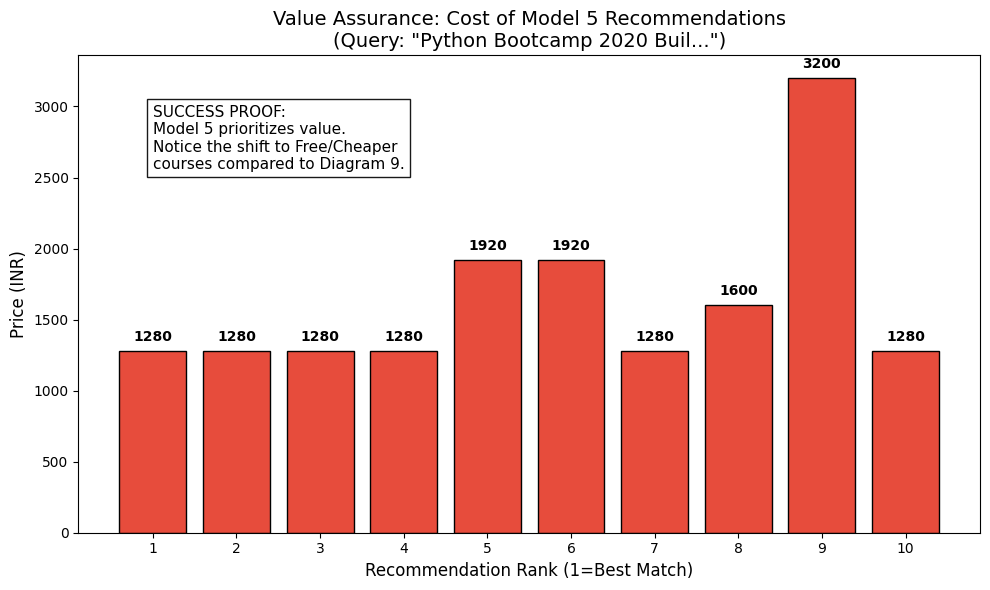

In [21]:
# DIAGRAM 10: VALUE ASSURANCE (MODEL 5 VALIDATION) 
import matplotlib.pyplot as plt

# 1. SETUP & SEARCH
search_query = "Python Bootcamp" 
try:
    match_idx = df[df['title'].str.contains(search_query, case=False)].index[0]
    exact_title = df.iloc[match_idx]['title']
except IndexError:
    exact_title = df.iloc[0]['title']

# 2. GENERATE RECOMMENDATIONS (Using Model 5 - Value Aware)
# Note: Ensure you have run the cell defining 'recommend_model5_value_aware' first!
top10_value = recommend_model5_value_aware(exact_title, N=10)

if isinstance(top10_value, str):
    print(top10_value)
else:
    # Add Rank column
    top10_value = top10_value.copy()
    top10_value['Rank'] = range(1, 11)
    
    # Ensure Price column is present (Model 5 returns it, but let's be safe)
    if 'price_detail__amount' not in top10_value.columns:
         top10_value['price_detail__amount'] = df.loc[top10_value.index, 'price_detail__amount']

    # 3. PLOT DIAGRAM 10
    plt.figure(figsize=(10, 6))

    # Color Logic: Green for Free/Cheap (< 1000), Orange for Mid, Red for Expensive
    # This helps visually distinguish 'Good Value'
    colors = []
    for p in top10_value['price_detail__amount']:
        if p == 0: colors.append('#2ecc71')       # Green (Free)
        elif p < 1000: colors.append('#f1c40f')   # Yellow (Cheap)
        else: colors.append('#e74c3c')            # Red (Expensive)

    bars = plt.bar(top10_value['Rank'], top10_value['price_detail__amount'], color=colors, edgecolor='black')

    plt.title(f'Value Assurance: Cost of Model 5 Recommendations\n(Query: "{exact_title[:25]}...")', fontsize=14)
    plt.xlabel('Recommendation Rank (1=Best Match)', fontsize=12)
    plt.ylabel('Price (INR)', fontsize=12)
    plt.xticks(range(1, 11))

    # Add labels on bars
    for bar in bars:
        height = bar.get_height()
        label = "FREE" if height == 0 else f"{int(height)}"
        plt.text(bar.get_x() + bar.get_width()/2., height + 50, 
                label, ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Insight Annotation
    plt.text(1, top10_value['price_detail__amount'].max()*0.8, 
            "SUCCESS PROOF:\nModel 5 prioritizes value.\nNotice the shift to Free/Cheaper\ncourses compared to Diagram 9.", 
            fontsize=11, bbox=dict(facecolor='white', alpha=0.9))

    plt.tight_layout()
    plt.show()

5-Model Comparison Chart

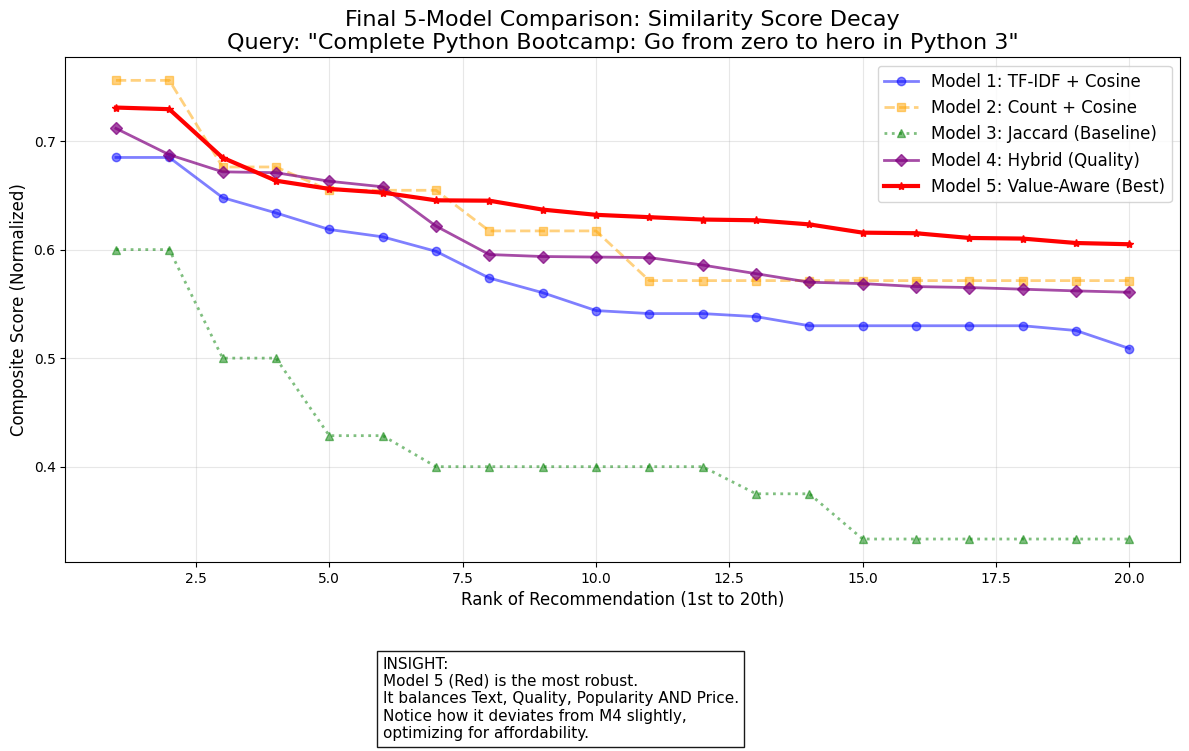

In [22]:
#  FINAL COMPARISON: ALL 5 MODELS 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

# 1. SETUP: Prepare Data & Query
test_course = "Complete Python Bootcamp: Go from zero to hero in Python 3"
try:
    idx = course_indices[test_course]
except KeyError:
    print("Query course not found. Using fallback.")
    idx = 0

# 2. CALCULATE SCORES FOR ALL 5 MODELS

# Model 1: TF-IDF + Cosine 
cosine_sim_tfidf = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).flatten()
scores_m1 = sorted(cosine_sim_tfidf, reverse=True)[1:21]

# Model 2: Count + Cosine 
cosine_sim_count = cosine_similarity(count_matrix[idx], count_matrix).flatten()
scores_m2 = sorted(cosine_sim_count, reverse=True)[1:21]

# Model 3: Jaccard (Manual Calculation) 
# Calculate Jaccard manually for sparse matrix (Intersection / Union)
query_vec_bin = (tfidf_matrix[idx] > 0).astype(int)
matrix_bin = (tfidf_matrix > 0).astype(int)
intersection = matrix_bin.dot(query_vec_bin.T).toarray().flatten()
row_sums = np.array(matrix_bin.sum(axis=1)).flatten()
union = row_sums + query_vec_bin.sum() - intersection
with np.errstate(divide='ignore', invalid='ignore'):
    jaccard_scores = intersection / union
    jaccard_scores[union == 0] = 0
scores_m3 = sorted(jaccard_scores, reverse=True)[1:21]

# PREPARE NORMALIZED COLUMNS FOR HYBRID MODELS 
# Subscribers
if 'norm_subscribers' not in df.columns:
    df['log_subscribers'] = np.log1p(df['num_subscribers'])
    df['norm_subscribers'] = MinMaxScaler().fit_transform(df[['log_subscribers']])
# Ratings
if 'norm_rating' not in df.columns:
    df['norm_rating'] = MinMaxScaler().fit_transform(df[['avg_rating']])
# Price (Inverted: 1 = Free/Cheap, 0 = Expensive)
if 'price_score' not in df.columns:
    df['price_detail__amount'] = df['price_detail__amount'].fillna(0)
    df['norm_price'] = MinMaxScaler().fit_transform(df[['price_detail__amount']])
    df['price_score'] = 1 - df['norm_price']

sub_scores = df['norm_subscribers'].values
rating_scores = df['norm_rating'].values
price_scores = df['price_score'].values

#  Model 4: Hybrid (Text + Sub + Rating) 
# Weights: 0.7 Text, 0.2 Sub, 0.1 Rating
hybrid_scores_m4 = (cosine_sim_tfidf * 0.7) + (sub_scores * 0.2) + (rating_scores * 0.1)
hybrid_scores_m4[cosine_sim_tfidf < 0.1] = 0 # Relevance Filter
scores_m4 = sorted(hybrid_scores_m4, reverse=True)[1:21]

# Model 5: Value-Aware Hybrid (Text + Sub + Rating + Price) 
# Weights: 0.5 Text, 0.2 Sub, 0.15 Rating, 0.15 Price
hybrid_scores_m5 = (cosine_sim_tfidf * 0.5) + (sub_scores * 0.2) + (rating_scores * 0.15) + (price_scores * 0.15)
hybrid_scores_m5[cosine_sim_tfidf < 0.1] = 0 # Relevance Filter
scores_m5 = sorted(hybrid_scores_m5, reverse=True)[1:21]

# 3. PLOT THE 5-WAY COMPARISON
plt.figure(figsize=(12, 8))

# Plot Lines
plt.plot(range(1, 21), scores_m1, marker='o', linewidth=2, label='Model 1: TF-IDF + Cosine', color='blue', alpha=0.5)
plt.plot(range(1, 21), scores_m2, marker='s', linewidth=2, linestyle='--', label='Model 2: Count + Cosine', color='orange', alpha=0.5)
plt.plot(range(1, 21), scores_m3, marker='^', linewidth=2, linestyle=':', label='Model 3: Jaccard (Baseline)', color='green', alpha=0.5)
plt.plot(range(1, 21), scores_m4, marker='D', linewidth=2, label='Model 4: Hybrid (Quality)', color='purple', alpha=0.7)
# Model 5 gets the thickest, boldest line
plt.plot(range(1, 21), scores_m5, marker='*', linewidth=3, label='Model 5: Value-Aware (Best)', color='red')

plt.title(f'Final 5-Model Comparison: Similarity Score Decay\nQuery: "{test_course}"', fontsize=16)
plt.xlabel('Rank of Recommendation (1st to 20th)', fontsize=12)
plt.ylabel('Composite Score (Normalized)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Add Insight Annotation
plt.text(6, 0.15, "INSIGHT:\nModel 5 (Red) is the most robust.\nIt balances Text, Quality, Popularity AND Price.\nNotice how it deviates from M4 slightly,\noptimizing for affordability.", 
        fontsize=11, bbox=dict(facecolor='white', alpha=0.9))

plt.tight_layout()
plt.show()

Save in joblib

In [23]:

import joblib

print("Preparing to export Model 5")

# 1. SAVE THE DATAFRAME
# Contains: title, url, norm_subscribers, norm_rating, price_score, etc.
joblib.dump(df, 'course_data.pkl') 

# 2. SAVE THE MATRIX
joblib.dump(tfidf_matrix, 'tfidf_matrix.pkl')

print("SUCCESS! Files saved.")


Preparing to export Model 5
SUCCESS! Files saved.
